In [1]:
import numpy as np

# Load the ragged array using np.load()

clusters = np.load("clusters_array.npy", allow_pickle=True)
medioids = np.load("medioids_array.npy")

print(clusters)
print(medioids)
# print(loaded_ragged_array)

[array([[29, 47],
        [49, 44],
        [30, 35],
        [41, 48],
        [33, 49],
        [39, 38],
        [37, 43],
        [47, 46],
        [32, 45],
        [32, 26],
        [31, 35],
        [37, 24],
        [34, 38],
        [34, 23],
        [41, 30],
        [32, 29],
        [34, 44],
        [30, 36],
        [34, 29],
        [37, 39],
        [32, 32],
        [44, 42],
        [37, 30],
        [44, 40],
        [36, 35],
        [40, 31],
        [27, 25],
        [49, 41],
        [38, 25],
        [42, 26],
        [31, 28]]) array([[ 4,  5],
                          [ 9, 18],
                          [14, 23],
                          [ 5,  1],
                          [17, 14],
                          [ 9, 16],
                          [18,  0],
                          [ 9,  9],
                          [ 8, 24],
                          [10,  2],
                          [23,  4],
                          [ 9,  1],
                          [2

In [2]:
r = 10.8484786346134


def D_vect(di, dj):
    return np.sqrt(np.sum(np.square(di - dj), axis=0))


data = []

for i, k in enumerate(medioids):
    for pt in clusters[i]:
        if D_vect(k, pt) > r:
            data.append(pt)

print(len(data))
data = np.array(data)

33


In [3]:
class Datum:
    def __init__(self, idx):
        self.idx = idx
        self.v = 0.0
        self.apdict = None


# Initialize input space
# M = np.random.randint(0, 50, (100, 2))
M = data
n = M.shape[0]


distances = np.sqrt(np.sum(np.square(M[:, np.newaxis, :] - M), axis=2))

# Step 1-2: Calculate denominators efficiently
denominators = np.sum(distances, axis=1)
# Calculate v values using vectorized operations
v_values = distances / denominators[:, np.newaxis]
np.fill_diagonal(v_values, 0)  # Set diagonal values to 0
v_sums = np.sum(v_values, axis=1)
# Initialize objects using list comprehension
data = [Datum(idx) for idx in range(n)]

# Assign calculated v values to data objects
for j in range(n):
    data[j].v = v_sums[j]

# Find the indices of top k medioids using argpartition
k = 4
medioid_indices = np.argpartition(v_sums, -k)[-k:]

# Sort the medioid indices by v values
medioid_indices = medioid_indices[np.argsort(v_sums[medioid_indices])]

In [4]:
def assign_clusters(dlen, mlist, distances):
    clusters = [[] for _ in mlist]

    for idx in range(dlen):
        distances_to_medioids = distances[idx, mlist]
        nearest_medioid_index = np.argmin(distances_to_medioids)
        clusters[nearest_medioid_index].append(idx)

    return clusters


def calculate_sum(clusters, mlist, distances):
    total_sum = np.sum(
        [distances[idx, midx] for midx in mlist for idx in clusters[mlist.index(midx)]]
    )
    return total_sum


def update_medioids(clusters, mlist, distances):
    new_mlist = []

    for midx in mlist:
        cluster = clusters[mlist.index(midx)]
        cluster_distances = np.sum(distances[cluster][:, cluster], axis=1)
        new_mlist.append(cluster[np.argmin(cluster_distances)])

    return new_mlist


def kmedioids(M, data, k=5, max_iter=100):
    sortkey = lambda d: d.v
    sorted_data = sorted(data, key=sortkey)
    medioid_indices = np.argpartition(np.array([d.v for d in sorted_data]), k)[:k]
    mlist = list(medioid_indices)
    n = M.shape[0]
    dlen = len(data)

    # Precompute distances
    distances = np.sqrt(np.sum(np.square(M[:, np.newaxis, :] - M), axis=2))

    total_sum = float("inf")
    for _ in range(max_iter):
        clusters = assign_clusters(dlen, mlist, distances)
        mlist = update_medioids(clusters, mlist, distances)
        new_sum = calculate_sum(clusters, mlist, distances)
        if new_sum == total_sum:
            break
        total_sum = new_sum

    return clusters, mlist


# Call kmedioids function
clusters, mlist = kmedioids(M, data, k, max_iter=100)
print(set(mlist))

{24, 0, 1, 15}


In [5]:
# clusters, mlist = kmedioids(M, data, k, 20)
medioids = np.array([M[idx] for idx in mlist])
for i in range(k):
    clusters[i] = np.stack(np.array([M[j] for j in clusters[i]]))

In [7]:
# Create a NumPy array with a ragged shape
ragged_array = np.array(clusters)

# Save the ragged array using np.save()
np.save("second_clusters_array.npy", ragged_array)
np.save("second_medioids_array.npy", medioids)

/tmp/ipykernel_20981/2152720306.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ragged_array = np.array(clusters)


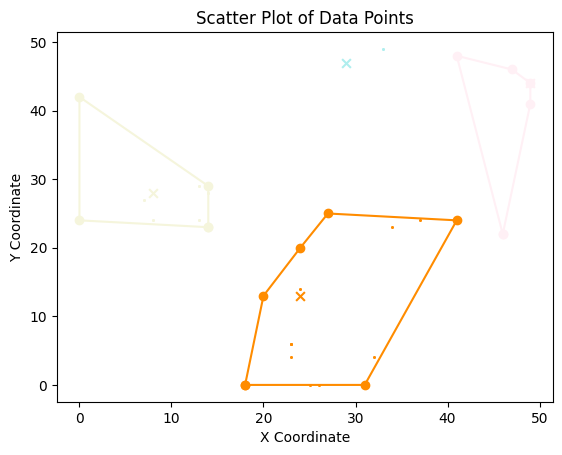

In [9]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


def graham_scan_convex_hull(points):
    def cross_product(p, q, r):
        return (q[0] - p[0]) * (r[1] - p[1]) - (r[0] - p[0]) * (q[1] - p[1])

    def polar_angle(p, q):
        return np.arctan2(q[1] - p[1], q[0] - p[0])

    # Find the point with the lowest y-coordinate (and leftmost if tied)
    start_point = min(points, key=lambda p: (p[1], p[0]))

    # Sort the points based on polar angles with respect to the start point
    sorted_points = sorted(
        points, key=lambda p: (polar_angle(start_point, p), -p[1], p[0])
    )

    # Initialize the convex hull with the first three sorted points
    convex_hull = [sorted_points[0], sorted_points[1], sorted_points[2]]

    # Iterate through the sorted points and construct the convex hull
    for point in sorted_points[3:]:
        while (
            len(convex_hull) >= 2
            and cross_product(convex_hull[-2], convex_hull[-1], point) <= 0
        ):
            convex_hull.pop()
        convex_hull.append(point)

    return convex_hull


# Reshape the array to (100, 2) for plotting
colors = list(set(mcolors.CSS4_COLORS))[::4]
# print(colors)
reshaped_centers = medioids.reshape(-1, 2)
cx_coords = reshaped_centers[:, 0]
cy_coords = reshaped_centers[:, 1]

for i, m in enumerate(clusters):
    # if len(m) > 3:
    # continue
    reshaped_data = m.reshape(-1, 2)
    # print(reshaped_data.shape)
    # Compute the convex hull using Graham Scan
    if len(m) > 2:
        convex_hull = graham_scan_convex_hull(reshaped_data)
        convex_hull.append(convex_hull[0])

        # Convert the convex hull points to a numpy array for visualization
        convex_hull_array = np.array(convex_hull)

        # Plot the original points and the convex hull

        plt.plot(
            convex_hull_array[:, 0],
            convex_hull_array[:, 1],
            c=colors[i],
            marker="o",
            label="Convex Hull",
        )
    plt.scatter(
        reshaped_data[:, 0], reshaped_data[:, 1], c=colors[i], label="Points", s=1
    )
    x_coords = reshaped_data[:, 0]
    y_coords = reshaped_data[:, 1]
    plt.scatter(x_coords, y_coords, marker="o", color=colors[i], s=1)
    plt.scatter(cx_coords[i], cy_coords[i], marker="x", color=colors[i], s=40)

# Add labels and title
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Scatter Plot of Data Points")

# Display the plot
plt.show()